In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','UlnarDeviation','RadialDeviation','Grip','AbductionOfFingers','AdductionOfFingers','Supination','Pronation']

In [3]:
def minimum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_minimum=ndimage.minimum_filter(raw,box_size,mode=mode)
    return raw_minimum.real

def median(raw, box_size, mode='nearest'): # Median Filter
    raw_median=ndimage.median_filter(raw,box_size,mode=mode)
    return raw_median.real

def maximum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation
    fft_signal = np.fft.fft(data)
    
    # Reconstruct the original signal
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing
    window_len=11  # extending the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

In [16]:
import warnings
warnings.filterwarnings('ignore') # too many warnings (use DataFrame.transpose instead of DataFrame.swapaxes)
c=0
for i in range(40): # data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_patterns'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for j in range(5): # pattern1 to pattern5
        globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_patterns'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
        
        for g in range(10): # gesture1 to gesture10
            #if j==0: # make arrays in person with gesture names
            globals()['data{}_{}_{}_signal'.format(i+1,gesture_names[g],j+1)] = globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[3200:18200,:] 
               
            #else: # horizontally concat later gesture arrays to the previously generated array
                #globals()['data{}_{}_signal'.format(i+1,gesture_names[g])] = np.concatenate((globals()['data{}_{}_signal'.format(i+1,gesture_names[g])],globals()['data{}_gestures{}'.format(i+1,j+1)][g].reset_index(drop=True).to_numpy()[2000:6000,:]),axis=0)

        c+=1
        #print('i:{} j:{} c:{}'.format(i+1,j+1,c))

In [17]:
data1_Rest_1_signal.shape

(15000, 4)

In [18]:
for i in range(40): # 40 data
    for g in gesture_names: # 10 gestures
        for j in range(5):
            globals()['data{}_{}_{}_filtered'.format(i+1,g,j+1)] = np.ndarray(globals()['data{}_{}_{}_signal'.format(i+1,g,j+1)].shape)
            for ch in range(4):
                globals()['data{}_{}_{}_filtered'.format(i+1,g,j+1)][:,ch] = smooth(denoise_fft(maximum(globals()['data{}_{}_{}_signal'.format(i+1,g,j+1)][:,ch],25)-minimum(globals()['data{}_{}_{}_signal'.format(i+1,g,j+1)][:,ch],20),10),5) # apply the filters

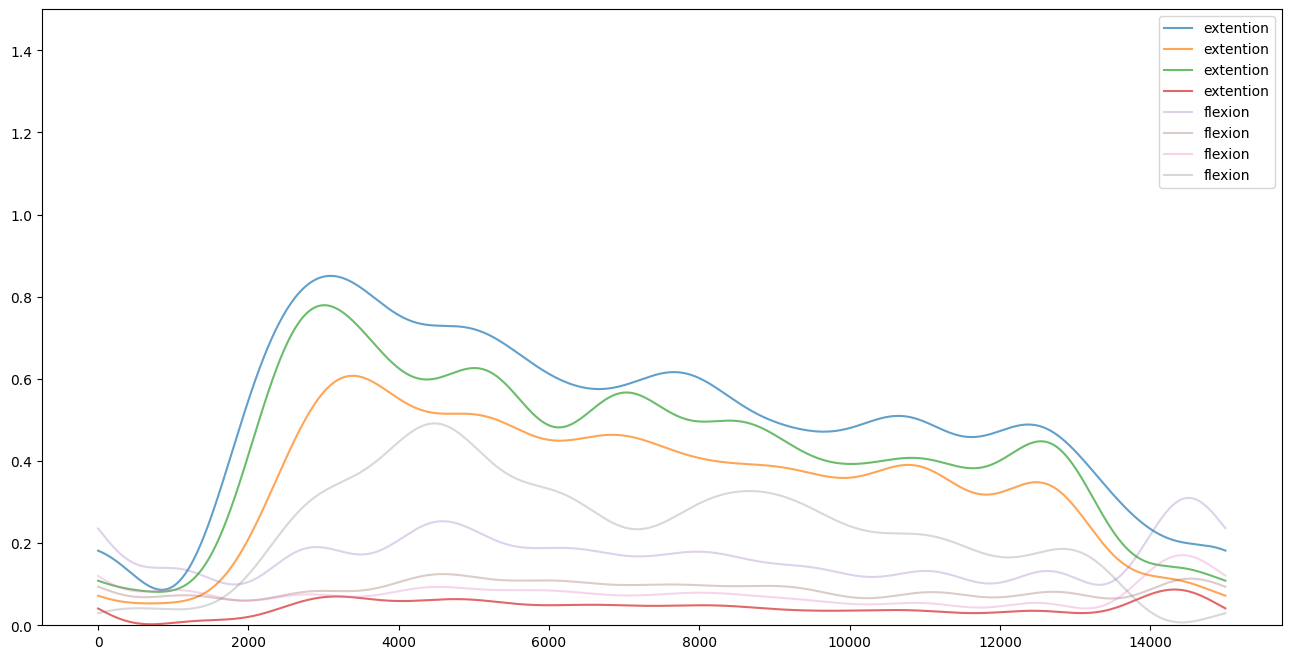

In [19]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(data4_Extension_1_filtered,label='extention',alpha=0.7)
ax.plot(data4_Flexion_1_filtered,label='flexion',alpha=0.3)

ax.set_ylim([0,1.5])
plt.legend()
plt.show()

In [37]:
data1_Extension_1_filtered

array([[0.13191083, 0.12046003, 0.04345365, 0.02562614],
       [0.13190567, 0.12044929, 0.04344778, 0.02562852],
       [0.13189107, 0.12041889, 0.04343118, 0.02563526],
       ...,
       [0.13204552, 0.12074381, 0.04360916, 0.02556234],
       [0.13202774, 0.12070605, 0.04358842, 0.02557091],
       [0.13201806, 0.12068551, 0.04357714, 0.02557557]])

In [65]:
df2 = pd.DataFrame(data1_Extension_1_filtered.T)
df2

,0,1,2,3,4,5,6,7,8,9,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,0.131911,0.131906,0.131891,0.131869,0.131843,0.131815,0.131787,0.131758,0.131729,0.131701,...,0.132231,0.132204,0.132177,0.132150,0.132122,0.132095,0.132069,0.132046,0.132028,0.132018
1,0.120460,0.120449,0.120419,0.120374,0.120319,0.120261,0.120203,0.120144,0.120085,0.120026,...,0.121142,0.121084,0.121025,0.120966,0.120908,0.120849,0.120793,0.120744,0.120706,0.120686
2,0.043454,0.043448,0.043431,0.043406,0.043377,0.043345,0.043313,0.043281,0.043249,0.043217,...,0.043829,0.043796,0.043764,0.043732,0.043699,0.043667,0.043636,0.043609,0.043588,0.043577
3,0.025626,0.025629,0.025635,0.025645,0.025657,0.025670,0.025683,0.025696,0.025709,0.025721,...,0.025471,0.025485,0.025498,0.025512,0.025525,0.025538,0.025551,0.025562,0.025571,0.025576


In [66]:
df2.insert(0, 'sequence', 1)
df2.insert(1, 'label', 1)
df2

,sequence,label,0,1,2,3,4,5,6,7,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,1,1,0.131911,0.131906,0.131891,0.131869,0.131843,0.131815,0.131787,0.131758,...,0.132231,0.132204,0.132177,0.132150,0.132122,0.132095,0.132069,0.132046,0.132028,0.132018
1,1,1,0.120460,0.120449,0.120419,0.120374,0.120319,0.120261,0.120203,0.120144,...,0.121142,0.121084,0.121025,0.120966,0.120908,0.120849,0.120793,0.120744,0.120706,0.120686
2,1,1,0.043454,0.043448,0.043431,0.043406,0.043377,0.043345,0.043313,0.043281,...,0.043829,0.043796,0.043764,0.043732,0.043699,0.043667,0.043636,0.043609,0.043588,0.043577
3,1,1,0.025626,0.025629,0.025635,0.025645,0.025657,0.025670,0.025683,0.025696,...,0.025471,0.025485,0.025498,0.025512,0.025525,0.025538,0.025551,0.025562,0.025571,0.025576


In [67]:
df1 = pd.DataFrame(data1_Rest_1_filtered.T)
df1.insert(0, 'sequence', 0)
df1.insert(1, 'label', 0)
df1

,sequence,label,0,1,2,3,4,5,6,7,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,0,0,0.100343,0.100350,0.100370,0.100400,0.100435,0.100473,0.100511,0.100550,...,0.099908,0.099945,0.099982,0.100019,0.100056,0.100093,0.100129,0.100161,0.100185,0.100198
1,0,0,0.110339,0.110336,0.110327,0.110314,0.110298,0.110281,0.110264,0.110247,...,0.110540,0.110523,0.110505,0.110488,0.110471,0.110454,0.110437,0.110423,0.110412,0.110405
2,0,0,0.036453,0.036453,0.036452,0.036451,0.036449,0.036447,0.036446,0.036444,...,0.036475,0.036473,0.036471,0.036469,0.036467,0.036466,0.036464,0.036462,0.036461,0.036460
3,0,0,0.020544,0.020545,0.020549,0.020556,0.020563,0.020571,0.020580,0.020588,...,0.020446,0.020455,0.020463,0.020472,0.020480,0.020488,0.020496,0.020503,0.020509,0.020512


In [68]:
df = pd.concat([df1,df2],axis=0)
df

,sequence,label,0,1,2,3,4,5,6,7,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,0,0,0.100343,0.100350,0.100370,0.100400,0.100435,0.100473,0.100511,0.100550,...,0.099908,0.099945,0.099982,0.100019,0.100056,0.100093,0.100129,0.100161,0.100185,0.100198
1,0,0,0.110339,0.110336,0.110327,0.110314,0.110298,0.110281,0.110264,0.110247,...,0.110540,0.110523,0.110505,0.110488,0.110471,0.110454,0.110437,0.110423,0.110412,0.110405
2,0,0,0.036453,0.036453,0.036452,0.036451,0.036449,0.036447,0.036446,0.036444,...,0.036475,0.036473,0.036471,0.036469,0.036467,0.036466,0.036464,0.036462,0.036461,0.036460
3,0,0,0.020544,0.020545,0.020549,0.020556,0.020563,0.020571,0.020580,0.020588,...,0.020446,0.020455,0.020463,0.020472,0.020480,0.020488,0.020496,0.020503,0.020509,0.020512
0,1,1,0.131911,0.131906,0.131891,0.131869,0.131843,0.131815,0.131787,0.131758,...,0.132231,0.132204,0.132177,0.132150,0.132122,0.132095,0.132069,0.132046,0.132028,0.132018
1,1,1,0.120460,0.120449,0.120419,0.120374,0.120319,0.120261,0.120203,0.120144,...,0.121142,0.121084,0.121025,0.120966,0.120908,0.120849,0.120793,0.120744,0.120706,0.120686
2,1,1,0.043454,0.043448,0.043431,0.043406,0.043377,0.043345,0.043313,0.043281,...,0.043829,0.043796,0.043764,0.043732,0.043699,0.043667,0.043636,0.043609,0.043588,0.043577
3,1,1,0.025626,0.025629,0.025635,0.025645,0.025657,0.025670,0.025683,0.025696,...,0.025471,0.025485,0.025498,0.025512,0.025525,0.025538,0.025551,0.025562,0.025571,0.025576


In [61]:
df.set_index(['sequence','label'], drop=True, inplace=True)
df

0         1         2         3         4         5      \
sequence label                                                               
0        0      0.100343  0.100350  0.100370  0.100400  0.100435  0.100473   
         0      0.110339  0.110336  0.110327  0.110314  0.110298  0.110281   
         0      0.036453  0.036453  0.036452  0.036451  0.036449  0.036447   
         0      0.020544  0.020545  0.020549  0.020556  0.020563  0.020571   
1        1      0.131911  0.131906  0.131891  0.131869  0.131843  0.131815   
         1      0.120460  0.120449  0.120419  0.120374  0.120319  0.120261   
         1      0.043454  0.043448  0.043431  0.043406  0.043377  0.043345   
         1      0.025626  0.025629  0.025635  0.025645  0.025657  0.025670   

                   6         7         8         9      ...     14990  \
sequence label                                          ...             
0        0      0.100511  0.100550  0.100588  0.100627  ...  0.099908   
         0      0.110264  0.110247  0.110230  0.110213  ...  0.110540   
         0      0.036446  0.036444  0.036442  0.036440  ...  0.036475   
         0      0.020580  0.020588  0.020596  0.020604  ...  0.020446   
1        1      0.131787  0.131758  0.131729  0.131701  ...  0.132231   
         1      0.120203  0.120144  0.120085  0.120026  ...  0.121142   
         1      0.043313  0.043281  0.043249  0.043217  ...  0.043829   
         1      0.025683  0.025696  0.025709  0.025721  ...  0.025471   

                   14991     14992     14993     14994     14995     14996  \
sequence label                                                               
0        0      0.099945  0.099982  0.100019  0.100056  0.100093  0.100129   
         0      0.110523  0.110505  0.110488  0.110471  0.110454  0.110437   
         0      0.036473  0.036471  0.036469  0.036467  0.036466  0.036464   
         0      0.020455  0.020463  0.020472  0.020480  0.020488  0.020496   
1        1      0.132204  0.132177  0.132150  0.132122  0.132095  0.132069   
         1      0.121084  0.121025  0.120966  0.120908  0.120849  0.120793   
         1      0.043796  0.043764  0.043732  0.043699  0.043667  0.043636   
         1      0.025485  0.025498  0.025512  0.025525  0.025538  0.025551   

                   14997     14998     14999  
sequence label                                
0        0      0.100161  0.100185  0.100198  
         0      0.110423  0.110412  0.110405  
         0      0.036462  0.036461  0.036460  
         0      0.020503  0.020509  0.020512  
1        1      0.132046  0.132028  0.132018  
         1      0.120744  0.120706  0.120686  
         1      0.043609  0.043588  0.043577  
         1      0.025562  0.025571  0.025576  

[8 rows x 15000 columns]

In [69]:
s = 0
for i in range(40): # 40 data
    for g in range(10): # 10 gestures
        for j in range(5):
            df_label = pd.DataFrame(globals()['data{}_{}_{}_filtered'.format(i+1,gesture_names[g],j+1)].T)
            df_label.insert(0, 'sequence', s)
            df_label.insert(1, 'label', g)
            df_label.set_index(['sequence','label'], drop=True, inplace=True)

            if s == 0:
                df = df_label
            else:
                df = pd.concat([df,df_label],axis=0)

            s +=1
            print(s)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [70]:
df

0         1         2         3         4         5      \
sequence label                                                               
0        0      0.100343  0.100350  0.100370  0.100400  0.100435  0.100473   
         0      0.110339  0.110336  0.110327  0.110314  0.110298  0.110281   
         0      0.036453  0.036453  0.036452  0.036451  0.036449  0.036447   
         0      0.020544  0.020545  0.020549  0.020556  0.020563  0.020571   
1        0      0.103840  0.103843  0.103849  0.103859  0.103871  0.103883   
...                  ...       ...       ...       ...       ...       ...   
1998     9      0.014313  0.014314  0.014318  0.014323  0.014329  0.014336   
1999     9      0.093110  0.093094  0.093051  0.092987  0.092911  0.092829   
         9      0.118611  0.118603  0.118581  0.118549  0.118510  0.118469   
         9      0.041952  0.041949  0.041943  0.041933  0.041921  0.041908   
         9      0.011159  0.011160  0.011163  0.011167  0.011172  0.011177   

                   6         7         8         9      ...     14990  \
sequence label                                          ...             
0        0      0.100511  0.100550  0.100588  0.100627  ...  0.099908   
         0      0.110264  0.110247  0.110230  0.110213  ...  0.110540   
         0      0.036446  0.036444  0.036442  0.036440  ...  0.036475   
         0      0.020580  0.020588  0.020596  0.020604  ...  0.020446   
1        0      0.103896  0.103909  0.103922  0.103935  ...  0.103698   
...                  ...       ...       ...       ...  ...       ...   
1998     9      0.014343  0.014350  0.014357  0.014364  ...  0.014234   
1999     9      0.092746  0.092663  0.092580  0.092497  ...  0.094083   
         9      0.118427  0.118385  0.118343  0.118301  ...  0.119101   
         9      0.041896  0.041883  0.041870  0.041857  ...  0.042102   
         9      0.011183  0.011188  0.011193  0.011199  ...  0.011096   

                   14991     14992     14993     14994     14995     14996  \
sequence label                                                               
0        0      0.099945  0.099982  0.100019  0.100056  0.100093  0.100129   
         0      0.110523  0.110505  0.110488  0.110471  0.110454  0.110437   
         0      0.036473  0.036471  0.036469  0.036467  0.036466  0.036464   
         0      0.020455  0.020463  0.020472  0.020480  0.020488  0.020496   
1        0      0.103710  0.103722  0.103734  0.103746  0.103758  0.103770   
...                  ...       ...       ...       ...       ...       ...   
1998     9      0.014241  0.014248  0.014254  0.014261  0.014268  0.014274   
1999     9      0.093999  0.093915  0.093831  0.093747  0.093663  0.093584   
         9      0.119059  0.119016  0.118974  0.118932  0.118890  0.118850   
         9      0.042089  0.042076  0.042063  0.042050  0.042037  0.042025   
         9      0.011102  0.011107  0.011113  0.011118  0.011123  0.011128   

                   14997     14998     14999  
sequence label                                
0        0      0.100161  0.100185  0.100198  
         0      0.110423  0.110412  0.110405  
         0      0.036462  0.036461  0.036460  
         0      0.020503  0.020509  0.020512  
1        0      0.103780  0.103788  0.103792  
...                  ...       ...       ...  
1998     9      0.014280  0.014285  0.014287  
1999     9      0.093513  0.093459  0.093430  
         9      0.118814  0.118787  0.118772  
         9      0.042014  0.042006  0.042001  
         9      0.011133  0.011137  0.011138  

[8000 rows x 15000 columns]

In [71]:
df.to_csv('reconstructed_data.csv')